In [1]:
import torch
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from data_utils import mnist_preparation, add_salt_and_pepper_noise 
from evaluationUtils import calculate_mcm_accuracy
from tqdm import tqdm
import matplotlib as plt
from mcmadaptablemodel import MCMQuantumModel, MCMCircuit
from pennylane import Device
from pennylane.measurements import StateMP
from torch.nn import Module, ParameterDict
import matplotlib.pyplot as plt
from OriginalModel import FullQuantumModel, QuantumCircuit
import warnings
from typing import Optional, Dict, List, Any
from torch.utils.data import DataLoader, dataloader
from time import time
import math
from pennylane.measurements import MidMeasureMP
torch.manual_seed(1234)

# Salt and Pepper

In [24]:
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                             ]))

In [25]:
sample_image, _ = mnist[0] 
noisy_image = add_salt_and_pepper_noise(sample_image, salt_prob=0.05, pepper_prob=0.05)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample_image.squeeze(), cmap='gray')
ax[0].set_title('Immagine originale')
ax[1].imshow(noisy_image.squeeze(), cmap='gray')
ax[1].set_title('Immagine con Salt & Pepper')
plt.show()

# Original Model performance


In [144]:
labels = [0,1,2,3]
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                #transforms.Lambda(lambda img: add_salt_and_pepper_noise(img, salt_prob=0.1, pepper_prob=0.1)),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))
#train/vali/test 70/15/15 split, see data_utils.py for further details
train_dataloader, validation_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.7,batch_size=64, vali_test_ratio=0.5)

print("Images in the training set: ", len(train_dataloader.dataset), "\n Images in the validation set: ", len(validation_dataloader.dataset), "\n Images in the test set: ", len(test_dataloader.dataset))

In [6]:
mcm_model =  MCMQuantumModel(qubits=8, layers=2, early_exits=[0])

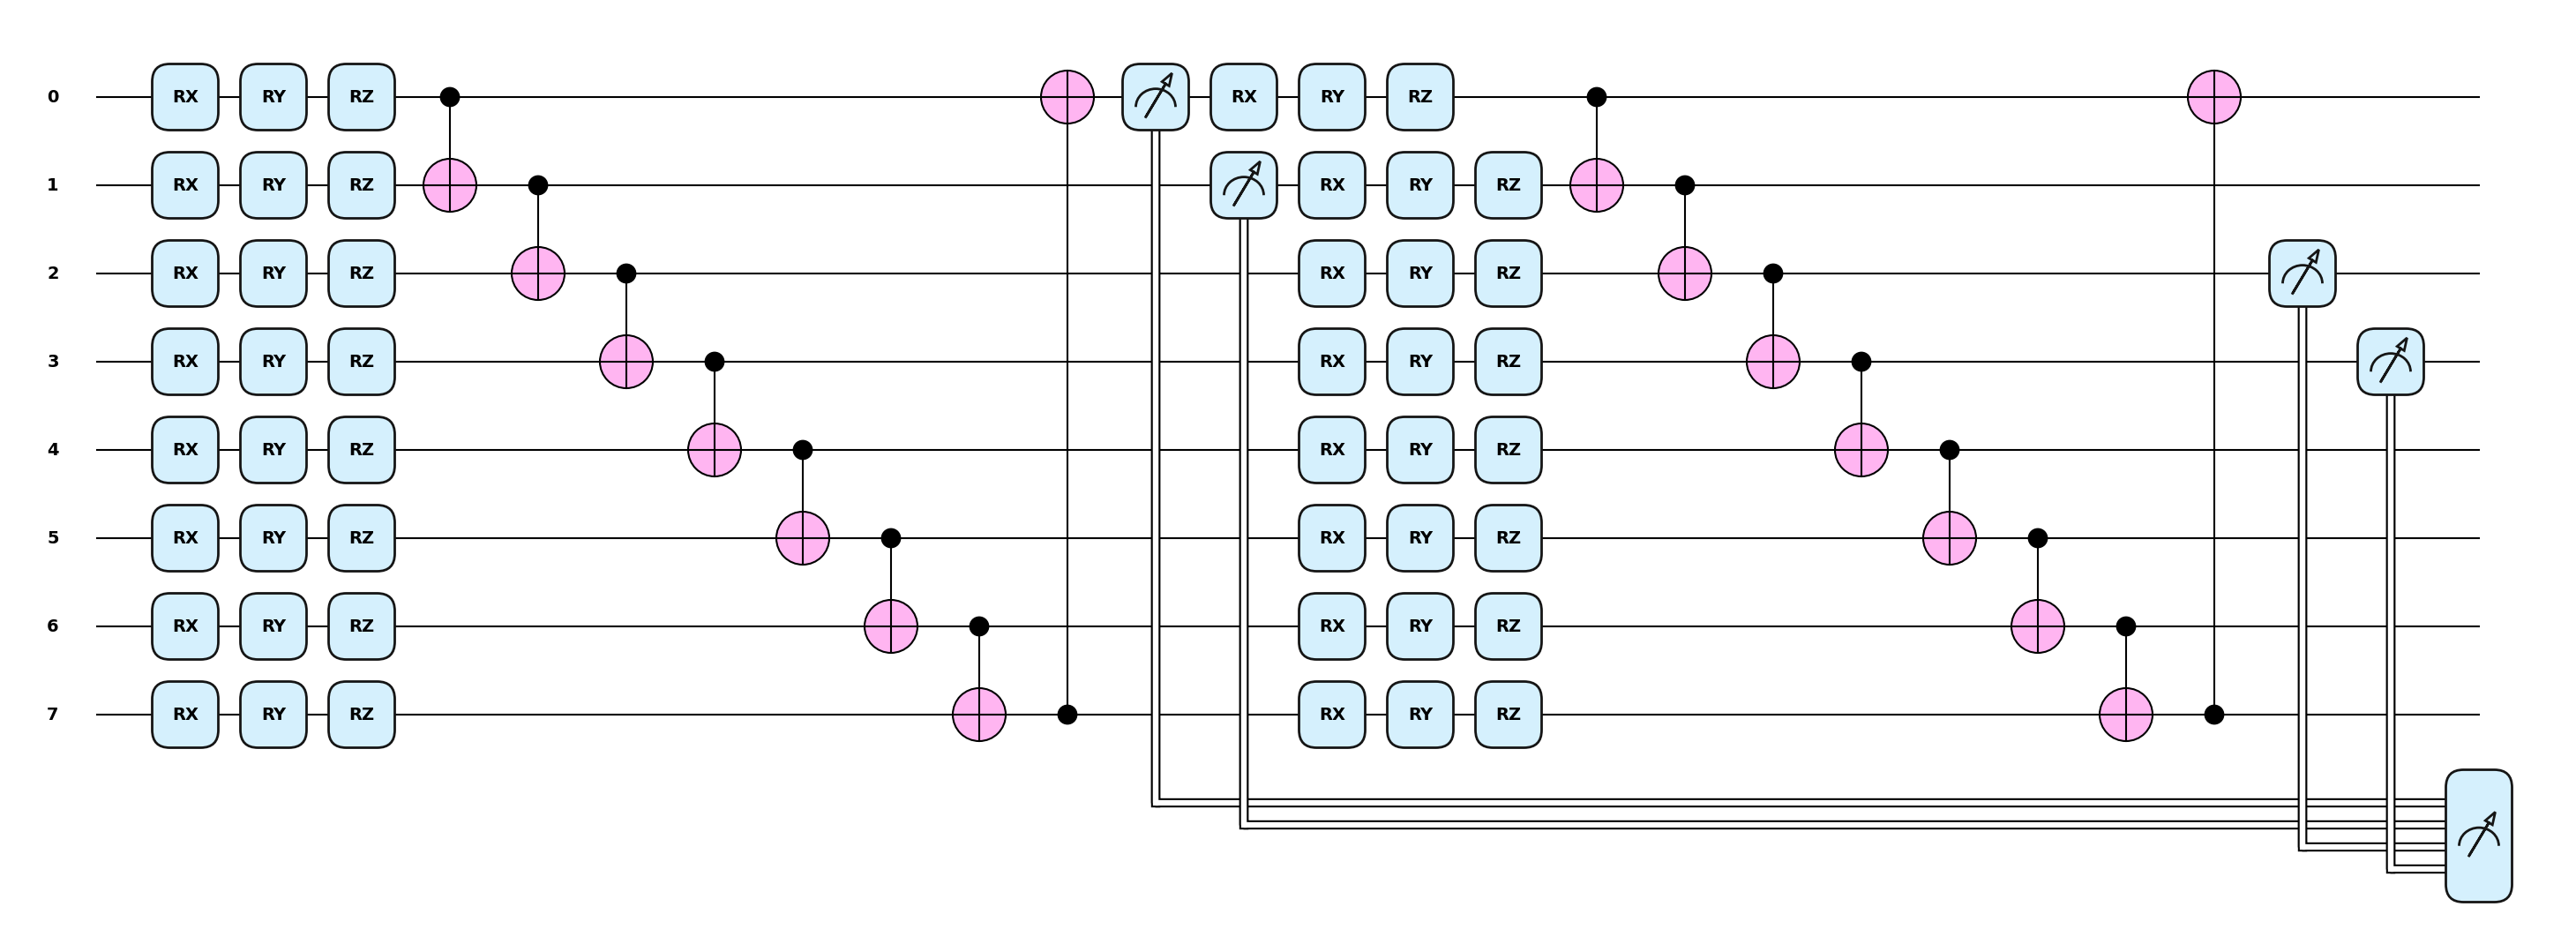

In [8]:
mcm_model.draw(style='pennylane', path='mcm_model.png')

In [147]:
mcm_accuracy, fm_accuracy, loss_history = mcm_model.fit(dataloader=train_dataloader, learning_rate=0.001, epochs=50, show_plot=True)

In [150]:
import pickle
model_params = mcm_model.params
with open("/Users/jackvittori/Desktop/analisi-rumore/no-rumore/pesi-history-50epochs-norumore.pickle", "wb") as file:
    pickle.dump(model_params, file)
    pickle.dump(mcm_accuracy, file)
    pickle.dump(fm_accuracy, file)
    pickle.dump(loss_history,file)

In [115]:
def early_evaluation_utils(params: Dict, state: torch.Tensor = None): 
    first_pair = [0,1]
    measurements = []
    if state is not None:
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(8))
    for i in range(4):
        for j in range(8):
            qml.RX(params[f'layer_{i}'][j, 0], wires=j)
            qml.RY(params[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(params[f'layer_{i}'][j, 2], wires=j)
        for j in range(8):
            qml.CNOT(wires=[j, (j + 1) % 8])
    
    for w in first_pair: 
        measurements.append(qml.measure(wires=w)) #measure first pair of qubits
    return measurements

def fully_evaluation_utils(params: Dict, state: torch.Tensor = None):
    first_pair = [0,1]
    second_pair = [2,3]
    mcasurements = []
    if state is not None:
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(8))
    for i in range(4):
        for j in range(8):
            qml.RX(params[f'layer_{i}'][j, 0], wires=j)
            qml.RY(params[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(params[f'layer_{i}'][j, 2], wires=j)
        for j in range(8):
            qml.CNOT(wires=[j, (j + 1) % 8])
            
    for w in first_pair: 
        mcasurements.append(qml.measure(wires=w)) #measure first pair of qubits

    for i in range(4, 8):
        for j in range(8):
            qml.RX(params[f'layer_{i}'][j, 0], wires=j)
            qml.RY(params[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(params[f'layer_{i}'][j, 2], wires=j)
        for j in range(8):
            qml.CNOT(wires=[j, (j + 1) % 8])

    for w in second_pair:
        mcasurements.append(qml.measure(wires=w))

    return mcasurements

In [116]:
dev = qml.device("default.qubit", wires=8)
@qml.qnode(dev)  
def early_evaluation_ansatz(params: Dict, state: torch.Tensor = None):
    early_measurement = early_evaluation_utils(params=params, state=state)
    return qml.probs(op=early_measurement)

@qml.qnode(dev)
def fully_evaluation_ansatz(params: Dict, state: torch.Tensor = None):
    measurements = fully_evaluation_utils(params=params, state=state)
    mid_measurement = measurements[:2]
    final_measurement = measurements[2:]
    return qml.probs(op=mid_measurement), qml.probs(op=final_measurement)

In [118]:
early_evaluate_model, ax1 = qml.draw_mpl(early_evaluation_ansatz)(model_params)

early_evaluate_model.savefig('early_evaluate_model.png')

In [119]:
final_evaluate_model, ax2 = qml.draw_mpl(fully_evaluation_ansatz)(model_params)

final_evaluate_model.savefig('final_evaluate_model.png')

In [137]:
def evaluation_routine(dataloader: DataLoader, parameters: Dict, threshold: float):
    
    evaluation_results = []
    early_results = []
    count_1 = 0 #counter for early classified images
    count_2 = 0 #counter for final classified images
    early_correct = 0 #counter for correctly early classified images 
    final_correct = 0 #counter for correctly final classified images
    executed_layers = 0
    for img, target in dataloader.dataset:
        #img normalization
        img = img / torch.linalg.norm(img).view(-1, 1)
        
        #mid circuit evaluation
        early_probs = early_evaluation_ansatz(params=parameters, state=img)
        early_prediction = torch.argmax(early_probs, dim=1)
        confidence = early_probs[0, early_prediction].item()
        early_guess = early_prediction == target
        early_results.append(early_guess.item())
        
        if confidence >= threshold:
            evaluation_results.append(early_guess.item())
            count_1 += 1
            executed_layers += 4
            if early_guess: 
                early_correct += 1
            
        else: 
            final_probs = fully_evaluation_ansatz(params=parameters, state=img)
            early_full, final_full = final_probs
            final_predictions = torch.argmax(final_full, dim=1)
            final_guess = final_predictions == target
            evaluation_results.append(final_guess.item())
            count_2 += 1
            executed_layers += 12
            
            if final_guess: 
                final_correct += 1
    total_accuracy = sum([1 for i in evaluation_results if i == True])/len(evaluation_results)
    early_total_accuracy = sum([1 for i in early_results if i == True])/len(early_results)
    early_exited_accuracy = early_correct/count_1 if count_1 > 0 else 0
    final_exited_accuracy = final_correct/count_2 if count_2 > 0 else 0
    
    return total_accuracy, early_total_accuracy, early_exited_accuracy, count_1, final_exited_accuracy, count_2, executed_layers

In [138]:
def explain_evaluation(dataloader: DataLoader, parameters: Dict, threshold: List[float]):
    summary_data = {
    'Threshold': [],
    'Total Accuracy': [],
    '# early exited images': [],
    'Early exited Accuracy': [],
    'Early total accuracy': [],
    '# final classified images': [],
    'Final classified Accuracy': [],
    "Executed layers": []}
    
    for t in tqdm(threshold):
        total_accuracy, early_total_accuracy, early_exited_accuracy, count_1, final_exited_accuracy, count_2, executed_layers = evaluation_routine(dataloader, parameters, t)
        summary_data['Threshold'].append(t)
        summary_data['Total Accuracy'].append(total_accuracy)
        summary_data['# early exited images'].append(count_1)
        summary_data['Early exited Accuracy'].append(early_exited_accuracy)
        summary_data['Early total accuracy'].append(early_total_accuracy)
        summary_data['# final classified images'].append(count_2)
        summary_data['Final classified Accuracy'].append(final_exited_accuracy)
        summary_data['Executed layers'].append(executed_layers)
        
    df = pd.DataFrame(summary_data)
    return summary_data, df

In [132]:
threshold = [0.25,0.26, 0.27, 0.28, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36]
explain_evaluation(test_dataloader, model_params, threshold)

In [131]:
double_exit = MCMQuantumModel(qubits=8, layers=8, early_exits=[3,4,5])
double_exit.draw(style="sketch", path='triple_exit.png')

In [133]:
labels = [0,1,2,3]
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                #transforms.Lambda(lambda img: add_salt_and_pepper_noise(img, salt_prob=0.13, pepper_prob=0.13)),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))
#train/vali/test 70/15/15 split, see data_utils.py for further details
train_dataloader, validation_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.7,batch_size=64, vali_test_ratio=0.5)

print("Images in the training set: ", len(train_dataloader.dataset), "\n Images in the validation set: ", len(validation_dataloader.dataset), "\n Images in the test set: ", len(test_dataloader.dataset))

In [134]:
model = MCMQuantumModel(qubits=8, layers=8, early_exits=[3])

with open("/Users/jackvittori/Desktop/pesimcm4.pickle", "rb") as file:
    params = pickle.load(file) 

model.set_parameters(params)

In [135]:
model.params['layer_0']

In [136]:
params['layer_0']

In [140]:
threshold = [0.25, 0.3, 0.35, 0.36, 0.37, 0.4]
explain_evaluation(test_dataloader, params, threshold)

In [1]:
import pickle

with open("/Users/jackvittori/Desktop/analisi-rumore/no-rumore/pesi-history-50epochs-norumore.pickle", "rb") as file:
    model_params = pickle.load(file)
    mcm_accuracy = pickle.load(file)
    fm_accuracy = pickle.load(file)
    loss_history = pickle.load(file)
    

In [2]:
model_params

In [5]:
mcm_accuracy